In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
# get_ipython().magic(u'matplotlib auto')
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# import torch
from tensorflow import keras
import statistics

In [2]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation
from tensorflow import reshape
from keras.utils import np_utils
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D,AveragePooling1D
from tensorflow.keras.layers import Input, LocallyConnected1D
from tensorflow.keras.layers import SeparableConv1D, Bidirectional
from tensorflow.keras.layers import LocallyConnected2D
from tensorflow.keras.layers import ZeroPadding2D,ZeroPadding1D, MaxPooling2D, Bidirectional
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import CSVLogger,LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [3]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import std
# import coremltools
# from torch import nn, optim
# import torch.nn.functional as F
import scipy.io
from scipy import stats
#from IPython.display import display, HTML
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU,SimpleRNN
from tensorflow.keras.layers import TimeDistributed
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

In [4]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(20, 14))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [5]:
# The number of steps within one time segment
TIME_PERIODS = 500
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 500
N_FEATURES = 10

In [6]:
column_names = ['C'+str(j) for j in range(1, N_FEATURES+1)]
lst = ['Class_label']
column_names = column_names+lst
print(column_names)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'Class_label']


In [7]:
def read_data_Train(file_path_Train):
    df_Train = pd.read_csv(file_path_Train,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Train['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Train['Class_label'] = df_Train['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Train.dropna(axis=0, how='any', inplace=True)
    return df_Train
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [8]:
def show_basic_dataframe_info(dataframe):
    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [9]:
def read_data_Test(file_path_Test):
    df_Test = pd.read_csv(file_path_Test,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Test['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Test['Class_label'] = df_Test['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Test.dropna(axis=0, how='any', inplace=True)
    return df_Test

In [10]:
 pd.options.display.float_format = "{:,.5f}".format

In [11]:
# 15 function to segment data into trial lengths (trial length =513 samples in this dataset)
def create_segments_and_labels(df, time_steps,step,n_features, label_name):
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
      for j in range(1, n_features+1):
        L = ('C'+str(j)) 
        segments.append(df[str(L)].values[i: i + time_steps])
      label = stats.mode(df[label_name][i: i + time_steps])[0][0]
      labels.append(label)
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, n_features)
    labels = np.asarray(labels)
    return reshaped_segments, labels

In [12]:
# import os
path='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/Total_process_TT/'

In [13]:
# file_path_train=path+'Train_data'+'.'+'csv'
file_path_train=path+'nina_pro_noprep_DB1_Train'+'.'+'csv'
print(file_path_train)

/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/Total_process_TT/nina_pro_noprep_DB1_Train.csv


In [14]:
file_path_test=path+'nina_pro_noprep_DB1_Test'+'.'+'csv'
# file_path_test=path+'Test_data'+'.'+'csv'
print(file_path_test)

/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/Total_process_TT/nina_pro_noprep_DB1_Test.csv


In [15]:
df_Train=read_data_Train(file_path_train)
show_basic_dataframe_info(df_Train)
df_Train.head(5)

Number of columns in the dataframe: 11
Number of rows in the dataframe: 4914000



,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label
0,0.01460,0.00240,0.00490,0.00240,0.00240,0.00240,0.00240,0.01710,0.00240,0.00240,1.00000
1,0.01710,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.02200,0.00240,0.00240,1.00000
2,0.03420,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.02690,0.00240,0.00240,1.00000
3,0.04390,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.02930,0.00240,0.00240,1.00000
4,0.04640,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.02930,0.00240,0.00240,1.00000


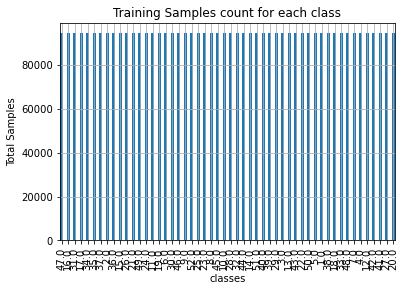

In [16]:
df_Train['Class_label'].value_counts().plot(kind='bar',
                                   title='Training Samples count for each class')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('Total Samples')
plt.xlabel('classes')
plt.grid(True)
plt.autoscale(axis='x',tight=True)

In [17]:
df_Test=read_data_Test(file_path_test)
show_basic_dataframe_info(df_Test)
df_Test.head(5)

Number of columns in the dataframe: 11
Number of rows in the dataframe: 2106000



,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label
0,0.03170,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.03910,0.00240,0.00240,1.00000
1,0.03910,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.04150,0.00240,0.00240,1.00000
2,0.03660,0.00240,0.00490,0.00240,0.00490,0.00240,0.00240,0.04150,0.00240,0.00240,1.00000
3,0.03660,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.04390,0.00240,0.00240,1.00000
4,0.02930,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.04390,0.00240,0.00240,1.00000


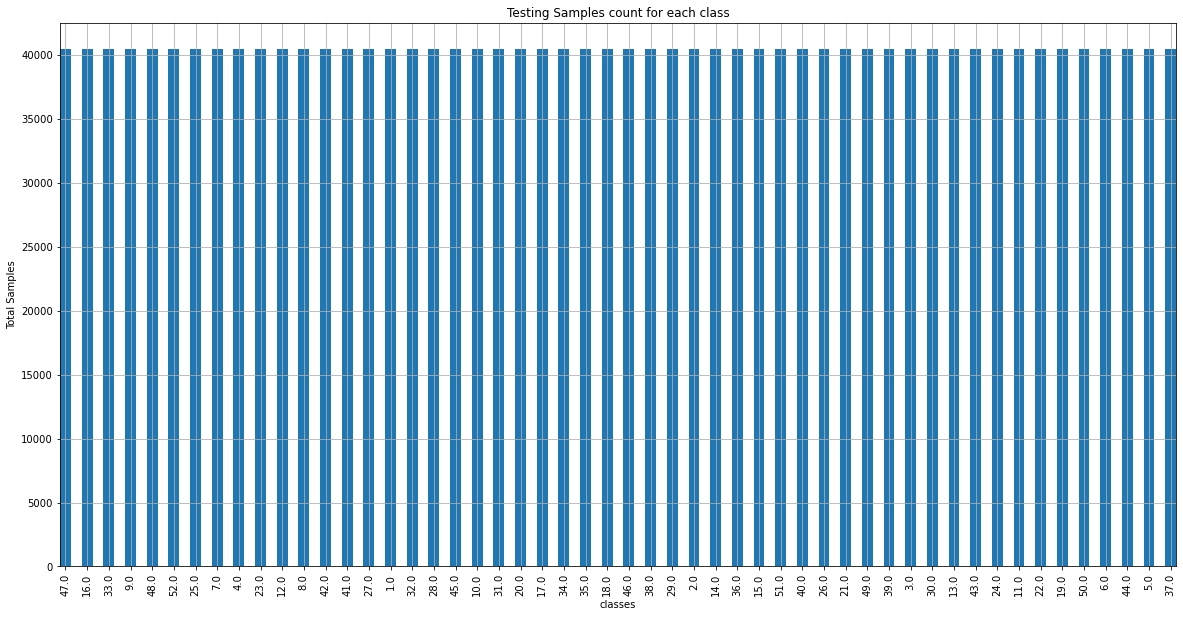

In [18]:
df_Test['Class_label'].value_counts().plot(kind='bar',
                                   title='Testing Samples count for each class')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('Total Samples')
plt.xlabel('classes')
plt.grid(True)
plt.autoscale(axis='x',tight=True)

In [19]:
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df_Train[LABEL] = le.fit_transform(df_Train['Class_label'].values.ravel())
# df_Valid[LABEL] = le.fit_transform(df_Valid['Class_label'].values.ravel())
df_Test[LABEL] = le.fit_transform(df_Test['Class_label'].values.ravel())

In [20]:
pd.options.display.float_format = "{:,.5f}".format
df_Train.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,0.01460,0.00240,0.00490,0.00240,0.00240,0.00240,0.00240,0.01710,0.00240,0.00240,1.00000,0
1,0.01710,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.02200,0.00240,0.00240,1.00000,0
2,0.03420,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.02690,0.00240,0.00240,1.00000,0
3,0.04390,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.02930,0.00240,0.00240,1.00000,0
4,0.04640,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.02930,0.00240,0.00240,1.00000,0


In [21]:
scaler = preprocessing.StandardScaler().fit(df_Train.iloc[:,0:N_FEATURES])

In [22]:
df_Train.iloc[:,0:N_FEATURES]=scaler.transform(df_Train.iloc[:,0:N_FEATURES])

In [23]:
pd.options.display.float_format = "{:,.5f}".format
df_Train.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,-0.62194,-0.58638,-0.47586,-0.39929,-0.33787,-0.42335,-0.71067,-0.83854,-0.47800,-0.72437,1.00000,0
1,-0.61714,-0.58638,-0.48164,-0.39929,-0.33787,-0.42335,-0.71067,-0.82968,-0.47800,-0.72437,1.00000,0
2,-0.58431,-0.58638,-0.48164,-0.39929,-0.33787,-0.42335,-0.71067,-0.82082,-0.47800,-0.72437,1.00000,0
3,-0.56569,-0.58638,-0.48164,-0.39929,-0.33787,-0.42335,-0.71067,-0.81648,-0.47800,-0.72437,1.00000,0
4,-0.56089,-0.58638,-0.48164,-0.39929,-0.33787,-0.42335,-0.71067,-0.81648,-0.47800,-0.72437,1.00000,0


In [24]:
pd.options.display.float_format = "{:,.5f}".format
df_Test.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,0.03170,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.03910,0.00240,0.00240,1.00000,0
1,0.03910,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.04150,0.00240,0.00240,1.00000,0
2,0.03660,0.00240,0.00490,0.00240,0.00490,0.00240,0.00240,0.04150,0.00240,0.00240,1.00000,0
3,0.03660,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.04390,0.00240,0.00240,1.00000,0
4,0.02930,0.00240,0.00240,0.00240,0.00240,0.00240,0.00240,0.04390,0.00240,0.00240,1.00000,0


In [25]:
df_Test.iloc[:,0:N_FEATURES]=scaler.transform(df_Test.iloc[:,0:N_FEATURES])

In [26]:
pd.options.display.float_format = "{:,.5f}".format
df_Test.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,-0.58911,-0.58638,-0.48164,-0.39929,-0.33787,-0.42335,-0.71067,-0.79876,-0.47800,-0.72437,1.00000,0
1,-0.57491,-0.58638,-0.48164,-0.39929,-0.33787,-0.42335,-0.71067,-0.79442,-0.47800,-0.72437,1.00000,0
2,-0.57970,-0.58638,-0.47586,-0.39929,-0.31418,-0.42335,-0.71067,-0.79442,-0.47800,-0.72437,1.00000,0
3,-0.57970,-0.58638,-0.48164,-0.39929,-0.33787,-0.42335,-0.71067,-0.79008,-0.47800,-0.72437,1.00000,0
4,-0.59372,-0.58638,-0.48164,-0.39929,-0.33787,-0.42335,-0.71067,-0.79008,-0.47800,-0.72437,1.00000,0


In [27]:
x_train, y_train = create_segments_and_labels(df_Train,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
print('x_train shape: ', x_train.shape)
# print(x_train)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
print('num_time_periods',num_time_periods)
print('num_sensors',num_sensors)
num_classes = le.classes_.size
print('class_list',list(le.classes_))
# input_shape = (num_time_periods,num_sensors)
# print(input_shape)
input_shape = (num_time_periods,num_sensors)
#x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train[0].shape)
print('input_shape:', input_shape)
x_train = x_train.astype('float32')
# x_train = [torch.tensor(arr, dtype=torch.float32) for arr in x_train]
# y_train = y_train.astype('float32')
# print(y_train)
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print(y_train_hot)
# y_train_hot= [torch.tensor(arr, dtype=torch.uint8) for arr in y_train_hot]
print('New y_train shape: ', y_train_hot.shape)

x_train shape:  (9827, 500, 10)
9827 training samples
y_train shape:  (9827,)
num_time_periods 500
num_sensors 10
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0]
x_train shape: (500, 10)
input_shape: (500, 10)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
New y_train shape:  (9827, 52)


In [28]:
x_test, y_test = create_segments_and_labels(df_Test,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
print('x_test shape: ', x_test.shape)
# print(x_train)
print(x_test.shape[0], 'testing samples')
print('y_test shape: ', y_test.shape)
# Set input_shape / reshape for Keras
#x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test_hot = np_utils.to_categorical(y_test, num_classes)

x_test shape:  (4211, 500, 10)
4211 testing samples
y_test shape:  (4211,)


In [29]:
# n_steps, n_length = 20, 25
# n_steps, n_length= 10, 50
# n_steps, n_length= 16, 32
n_steps, n_length = 25, 20
n_depth=10
x_train = x_train.reshape(x_train.shape[0], n_steps, n_length,n_depth)
print('x_train shape: ', x_train.shape)
# x_valid = x_valid.reshape(x_valid.shape[0], n_steps, n_length, n_depth)
# print('x_valid shape: ', x_valid.shape)
x_test = x_test.reshape(x_test.shape[0], n_steps, n_length,n_depth)
print('x_test shape: ', x_test.shape)
n_outputs = y_train_hot.shape[1]
print('n_outputs',n_outputs)

x_train shape:  (9827, 25, 20, 10)
x_test shape:  (4211, 25, 20, 10)
n_outputs 52


In [30]:
LABELS=[]
for i in range(1,n_outputs+1,1):
  LABELS.append (i)
print(LABELS)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]


In [31]:
def step_decay(epoch):
  initial_lrate = 1e-4
  drop = 0.1
  epochs_drop = 70.0
  lrate = initial_lrate * tf.math.pow(drop,  
          tf.math.floor((1+epoch)/epochs_drop))
  return lrate

In [32]:
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [43]:
verbose, epochs, batch_size = 0, 200, 64

In [44]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=9, padding='same', kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04)), \
                           input_shape=(n_steps,n_length,n_depth)))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(MaxPooling1D(pool_size=8,strides=2)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=5,padding="same",kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04))))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Dropout(0.2093)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=5,padding="same",kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04))))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Dropout(0.2093)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3,padding="same",kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04))))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Dropout(0.2093)))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(Flatten()))
# model.add(Flatten())
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(SimpleRNN(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(SimpleRNN(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(BatchNormalization(epsilon=1e-05, momentum=0.9, weights=None))
# model.add(Bidirectional(SimpleRNN(200)))
# model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='tanh'))
# model.add(Dense(200, activation='tanh'))
model.add(BatchNormalization(epsilon=1e-05, momentum=0.9, weights=None))
model.add(Dense(n_outputs, activation='softmax'))

In [45]:
adam=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
checkpoint_filepath = '/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/checkpoint.hdf5'
# model.load_weights(checkpoint_filepath) 
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,verbose=1, monitor='val_accuracy',save_weights_only=True,save_best_only=True)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_36 (TimeDis (None, 25, 10, 64)        5824      
_________________________________________________________________
time_distributed_37 (TimeDis (None, 25, 10, 64)        256       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 25, 2, 64)         0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 25, 2, 64)         0         
_________________________________________________________________
time_distributed_40 (TimeDis (None, 25, 1, 64)         20544     
_________________________________________________________________
time_distributed_41 (TimeDis (None, 25, 1, 64)         256       
_________________________________________________________________
time_distributed_42 (TimeDis (None, 25, 1, 64)        

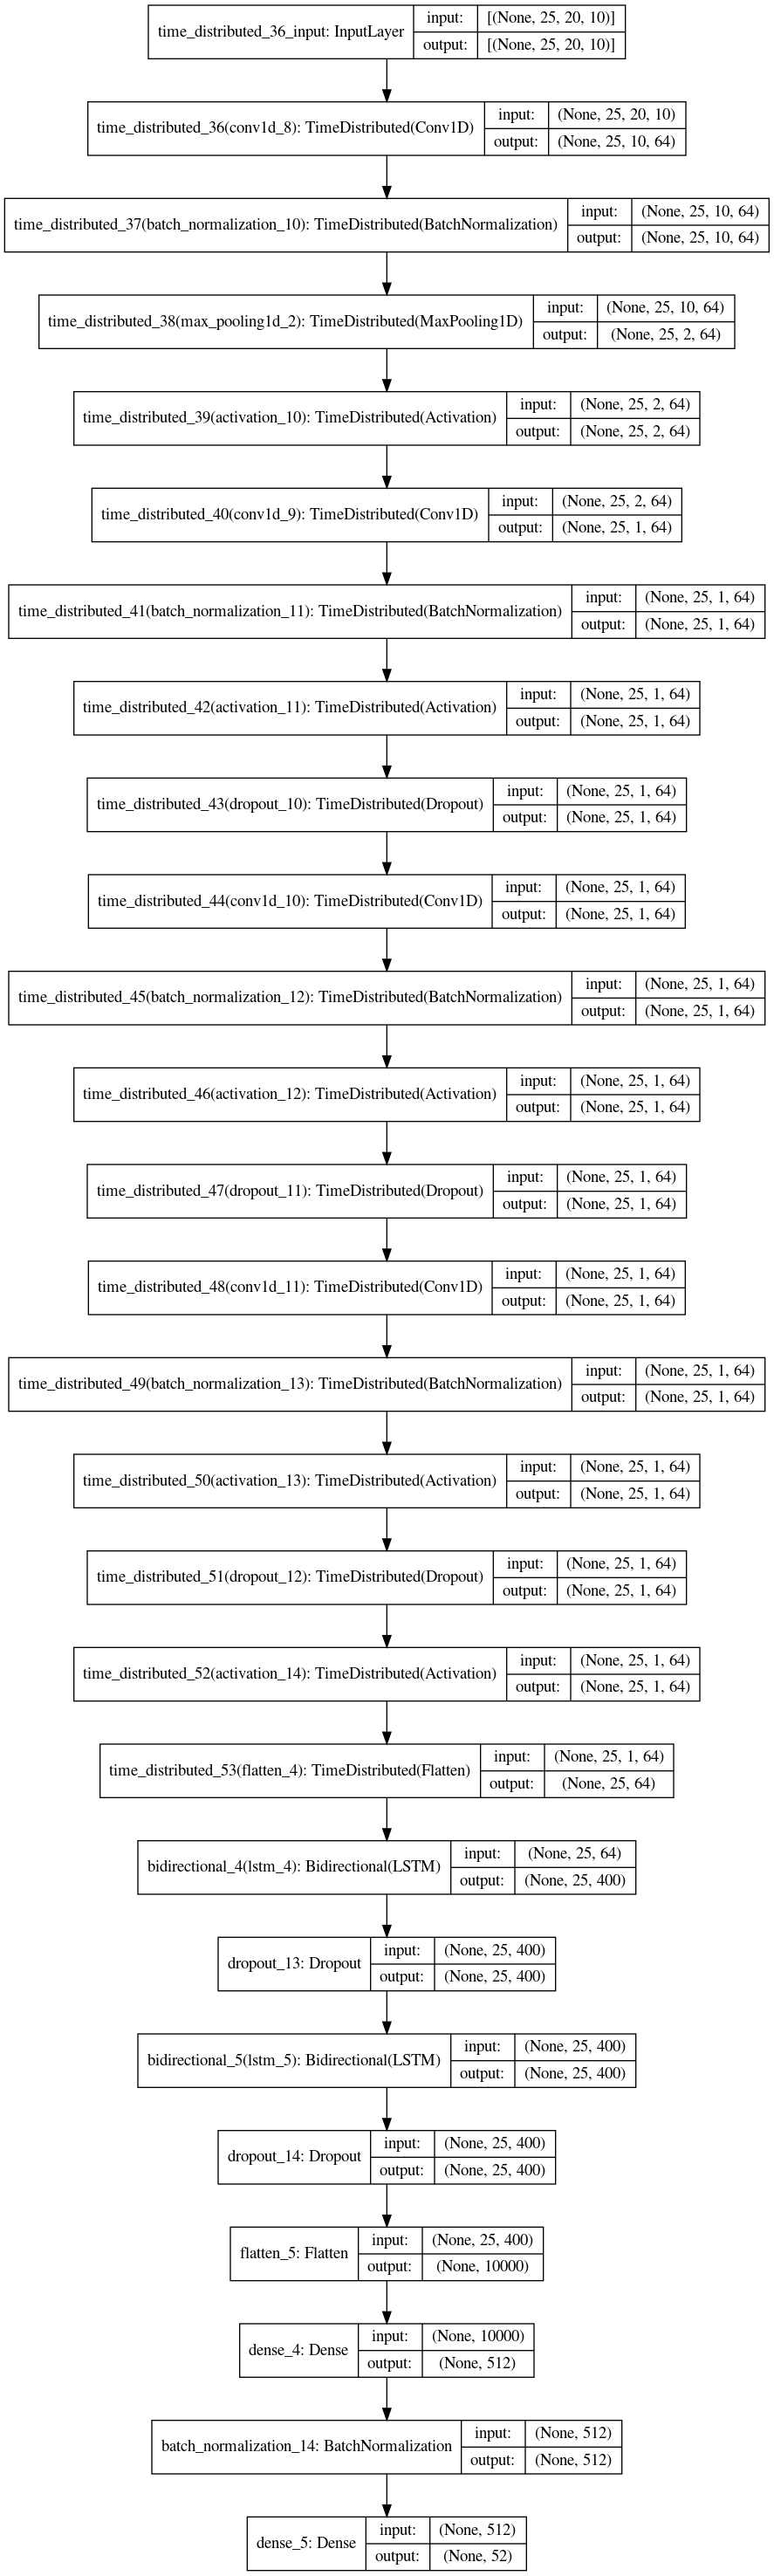

In [46]:
tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)

In [47]:
# adam=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# sgd=tfa.optimizers.SGDW(weight_decay=0.0001,learning_rate=0.1, momentum=0.9, nesterov=False, name='SGDW')
# sgd=tf.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False, name='SGD')
#     tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/olsson/CNN20X10/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)
csv_logger = CSVLogger('/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/CNN_nina_20X10.csv', append=True, separator=';')
history = model.fit(x_train, y_train_hot, epochs=epochs, batch_size=batch_size, callbacks=[csv_logger,checkpoint_callback,lrate,early],validation_data=(x_test, y_test_hot), verbose=1)
best_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
print('epoch_number',best_index+1)

Epoch 1/200
154/154 [==============================] - 21s 78ms/step - loss: 4.5369 - accuracy: 0.0660 - val_loss: 3.3423 - val_accuracy: 0.2140

Epoch 00001: val_accuracy improved from -inf to 0.21396, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/checkpoint.hdf5
Epoch 2/200
154/154 [==============================] - 4s 26ms/step - loss: 3.4986 - accuracy: 0.1699 - val_loss: 3.0252 - val_accuracy: 0.2691

Epoch 00002: val_accuracy improved from 0.21396 to 0.26906, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/checkpoint.hdf5
Epoch 3/200
154/154 [==============================] - 4s 25ms/step - loss: 3.2252 - accuracy: 0.2237 - val_loss: 2.8136 - val_accuracy: 0.3094

Epoch 00003: val_accuracy improved from 0.26906 to 0.30943, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/checkpoint.hdf5
Epoch 4/200
154/154 [========================


Epoch 00027: val_accuracy improved from 0.69722 to 0.69888, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/checkpoint.hdf5
Epoch 28/200
154/154 [==============================] - 4s 26ms/step - loss: 1.2702 - accuracy: 0.6683 - val_loss: 1.0910 - val_accuracy: 0.7229

Epoch 00028: val_accuracy improved from 0.69888 to 0.72287, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/checkpoint.hdf5
Epoch 29/200
154/154 [==============================] - 4s 25ms/step - loss: 1.2239 - accuracy: 0.6819 - val_loss: 1.0874 - val_accuracy: 0.7276

Epoch 00029: val_accuracy improved from 0.72287 to 0.72762, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/checkpoint.hdf5
Epoch 30/200
154/154 [==============================] - 4s 26ms/step - loss: 1.1753 - accuracy: 0.6921 - val_loss: 1.0409 - val_accuracy: 0.7364

Epoch 00030: val_accuracy improved from

154/154 [==============================] - 4s 26ms/step - loss: 0.4368 - accuracy: 0.9202 - val_loss: 0.6489 - val_accuracy: 0.8554

Epoch 00055: val_accuracy improved from 0.85348 to 0.85538, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/checkpoint.hdf5
Epoch 56/200
154/154 [==============================] - 4s 26ms/step - loss: 0.4302 - accuracy: 0.9242 - val_loss: 0.6448 - val_accuracy: 0.8608

Epoch 00056: val_accuracy improved from 0.85538 to 0.86084, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/checkpoint.hdf5
Epoch 57/200
154/154 [==============================] - 4s 25ms/step - loss: 0.4164 - accuracy: 0.9272 - val_loss: 0.6386 - val_accuracy: 0.8594

Epoch 00057: val_accuracy did not improve from 0.86084
Epoch 58/200
154/154 [==============================] - 4s 25ms/step - loss: 0.4035 - accuracy: 0.9306 - val_loss: 0.6311 - val_accuracy: 0.8656

Epoch 00058: val_accuracy 

154/154 [==============================] - 4s 26ms/step - loss: 0.2362 - accuracy: 0.9873 - val_loss: 0.5468 - val_accuracy: 0.8884

Epoch 00087: val_accuracy did not improve from 0.88934
Epoch 88/200
154/154 [==============================] - 4s 26ms/step - loss: 0.2351 - accuracy: 0.9897 - val_loss: 0.5474 - val_accuracy: 0.8891

Epoch 00088: val_accuracy did not improve from 0.88934
Epoch 89/200
154/154 [==============================] - 4s 26ms/step - loss: 0.2354 - accuracy: 0.9868 - val_loss: 0.5437 - val_accuracy: 0.8896

Epoch 00089: val_accuracy improved from 0.88934 to 0.88957, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/checkpoint.hdf5
Epoch 90/200
154/154 [==============================] - 4s 26ms/step - loss: 0.2334 - accuracy: 0.9871 - val_loss: 0.5443 - val_accuracy: 0.8922

Epoch 00090: val_accuracy improved from 0.88957 to 0.89219, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_p

154/154 [==============================] - 4s 26ms/step - loss: 0.2170 - accuracy: 0.9893 - val_loss: 0.5386 - val_accuracy: 0.8886

Epoch 00126: val_accuracy did not improve from 0.89219
Epoch 127/200
154/154 [==============================] - 4s 26ms/step - loss: 0.2097 - accuracy: 0.9933 - val_loss: 0.5322 - val_accuracy: 0.8922

Epoch 00127: val_accuracy did not improve from 0.89219
Epoch 128/200
154/154 [==============================] - 4s 25ms/step - loss: 0.2143 - accuracy: 0.9914 - val_loss: 0.5335 - val_accuracy: 0.8912

Epoch 00128: val_accuracy did not improve from 0.89219
Epoch 129/200
154/154 [==============================] - 4s 26ms/step - loss: 0.2152 - accuracy: 0.9900 - val_loss: 0.5316 - val_accuracy: 0.8915

Epoch 00129: val_accuracy did not improve from 0.89219
Epoch 130/200
154/154 [==============================] - 4s 26ms/step - loss: 0.2132 - accuracy: 0.9908 - val_loss: 0.5342 - val_accuracy: 0.8898

Epoch 00130: val_accuracy did not improve from 0.89219
Epoc

154/154 [==============================] - 4s 26ms/step - loss: 0.2047 - accuracy: 0.9926 - val_loss: 0.5302 - val_accuracy: 0.8915

Epoch 00165: val_accuracy did not improve from 0.89432
Epoch 166/200
154/154 [==============================] - 4s 27ms/step - loss: 0.2054 - accuracy: 0.9932 - val_loss: 0.5292 - val_accuracy: 0.8898

Epoch 00166: val_accuracy did not improve from 0.89432
Epoch 167/200
154/154 [==============================] - 4s 26ms/step - loss: 0.2043 - accuracy: 0.9953 - val_loss: 0.5290 - val_accuracy: 0.8908

Epoch 00167: val_accuracy did not improve from 0.89432
Epoch 168/200
154/154 [==============================] - 4s 26ms/step - loss: 0.2054 - accuracy: 0.9936 - val_loss: 0.5287 - val_accuracy: 0.8934

Epoch 00168: val_accuracy did not improve from 0.89432
Epoch 169/200
154/154 [==============================] - 4s 28ms/step - loss: 0.2085 - accuracy: 0.9916 - val_loss: 0.5304 - val_accuracy: 0.8919

Epoch 00169: val_accuracy did not improve from 0.89432
Epoc

In [48]:
import datetime

In [49]:
print('train accuracy and validation accuracy', history.history['accuracy'][best_index], history.history['val_accuracy'][best_index])
model.load_weights(checkpoint_filepath) 
print(datetime.datetime.now())
_, testaccuracy = model.evaluate(x_test, y_test_hot, batch_size=batch_size, verbose=1)
print(datetime.datetime.now())
print('test_accuracy',testaccuracy)
# test_acc.append(testaccuracy)

train accuracy and validation accuracy 0.9924697279930115 0.8950368165969849
2021-11-10 16:59:56.062648
66/66 [==============================] - 1s 10ms/step - loss: 0.5276 - accuracy: 0.8950
2021-11-10 16:59:56.788351
test_accuracy 0.8950368165969849


In [50]:
model.save('/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/CNN_LSTM_nina_5X97')

INFO:tensorflow:Assets written to: /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/CNN_LSTM_nina_5X97/assets


INFO:tensorflow:Assets written to: /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/prep_no_prep/CNN25X20/CNN_LSTM_nina_5X97/assets


history loss
history accuracy
history val_loss
history val_accuracy
history lr


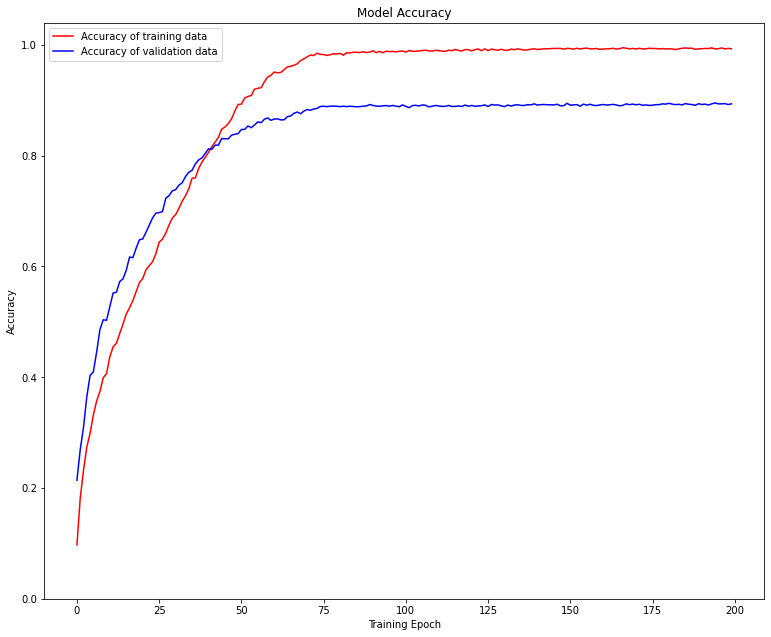

In [51]:
for i in history.history:
    print("history",i)
# facecolor='black'
DB1a=plt.figure(figsize=(10, 8),edgecolor='black')
# ax=figDB4.add_axes(("left", "bottom", "width", "height"))
ax= DB1a.add_axes((1,1,1,1))
ax.spines["top"].set_position(("outward", 0))
ax.spines["bottom"].set_position(("data", 0))
ax.spines["left"].set_position(("axes", 0))
ax.spines["right"].set_position(("outward", 0))

ax.spines["top"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black")

# ax.spines["left"].set_bounds(-.5, .5)
# ax.spines["right"].set_linestyle("--")
# ax.spines["bottom"].set_linewidth(6)
# ax.spines["bottom"].set_capstyle("round")

# plt2.rcParams['figure.facecolor'] = 'white'
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')

# plt2.ylim(0)
# plt2.rcParams['figure.facecolor'] = 'white'

# ax = fig.add_axes((left, bottom, width, height))
ax.set(facecolor="white")
# ax.patch.set_alpha(1.0)
plt.ylim(0)
plt.legend()
plt.show()

history loss
history accuracy
history val_loss
history val_accuracy
history lr


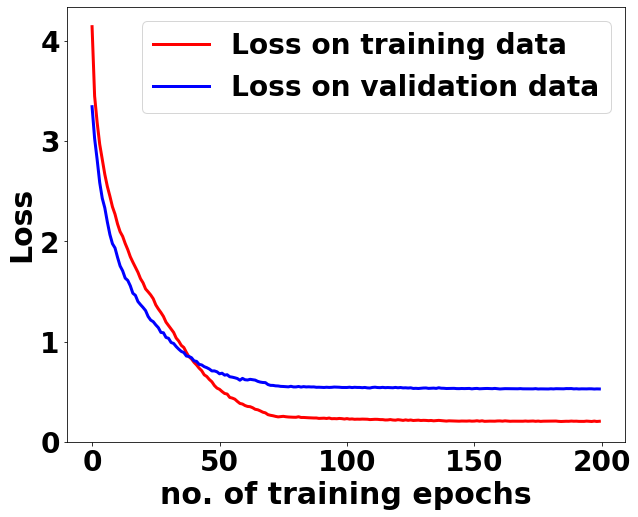

In [52]:
for i in history.history:
    print("history",i)
# facecolor='black'
# ax= figDB1.add_axes((1,1,1,1))
# ax.spines["top"].set_position(("outward", 0))
# ax.spines["bottom"].set_position(("data", 0))
# ax.spines["left"].set_position(("axes", 0))
# ax.spines["right"].set_position(("outward", 0))

# ax.spines["top"].set_color("black")
# ax.spines["left"].set_color("black")
# ax.spines["right"].set_color("black")
# ax.spines["bottom"].set_color("black") 

figDB1=plt.figure(figsize=(10, 8),edgecolor='black')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 28}

plt.rc('font', **font)

# SMALL_SIZE = 12
# MEDIUM_SIZE = 14
# BIGGER_SIZE = 18

# figBPR.suptitle('test title', fontsize=20)
#plt.rc('xlabel', fontsize=14, weight = 'bold')
#plt.rc('ylabel', fontsize=14, weight = 'bold')

# plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
# plt.rc('axes', labelsize=MEDIUM_SIZE )     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE, weight = 'bold')    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE )  # fontsize of the figure title

# ax=figDB1.add_axes(("left", "bottom", "width", "height"))
# ax= figDB1.add_axes((1,1,1,1))
# ax.spines["top"].set_position(("outward", 0))
# ax.spines["bottom"].set_position(("data", 0))
# ax.spines["left"].set_position(("axes", 0))
# ax.spines["right"].set_position(("outward", 0))

# ax.spines["top"].set_color("black")
# ax.spines["left"].set_color("black")
# ax.spines["right"].set_color("black")
# ax.spines["bottom"].set_color("black")

# ax.spines["left"].set_bounds(-.5, .5)
# ax.spines["right"].set_linestyle("--")
ax.spines["top"].set_linewidth(3)
ax.spines["top"].set_linestyle("-")
ax.spines["bottom"].set_linewidth(3)
ax.spines["bottom"].set_linestyle("-")
ax.spines["left"].set_linewidth(3)
ax.spines["left"].set_linestyle("-")
ax.spines["right"].set_linewidth(3)
ax.spines["right"].set_linestyle("-")
# ax.spines["bottom"].set_capstyle("round")

# plt2.rcParams['figure.facecolor'] = 'white'
plt.plot(history.history['loss'], 'r-', linewidth=3, label='Loss on training data')
plt.plot(history.history['val_loss'], 'b-', linewidth=3, label='Loss on validation data')
# plt.title('Loss curve for NinaPro DB1',fontsize=18, weight = 'bold')

plt.ylabel('Loss',fontsize=30, weight = 'bold')
plt.xlabel('no. of training epochs',fontsize=30, weight = 'bold')
# plt2.ylim(0)
# plt2.rcParams['figure.facecolor'] = 'white'

# ax = fig.add_axes((left, bottom, width, height))
ax.set(facecolor="white")
# ax.patch.set_alpha(1.0)
plt.ylim(0)
plt.legend()
plt.show()

In [53]:
# figDB1.savefig('/media/naveen/nav/plots/NinaPro_DB1_25X20.eps',transparent=False)
# figDB1.savefig('/media/naveen/nav/plots/NinaPro_DB1_25X20.pdf',transparent=False)

In [54]:
model.load_weights(checkpoint_filepath) 
_, testaccuracy = model.evaluate(x_test, y_test_hot, batch_size=batch_size, verbose=1)
print('test_accuracy',testaccuracy)

66/66 [==============================] - 1s 11ms/step - loss: 0.5276 - accuracy: 0.8950
test_accuracy 0.8950368165969849


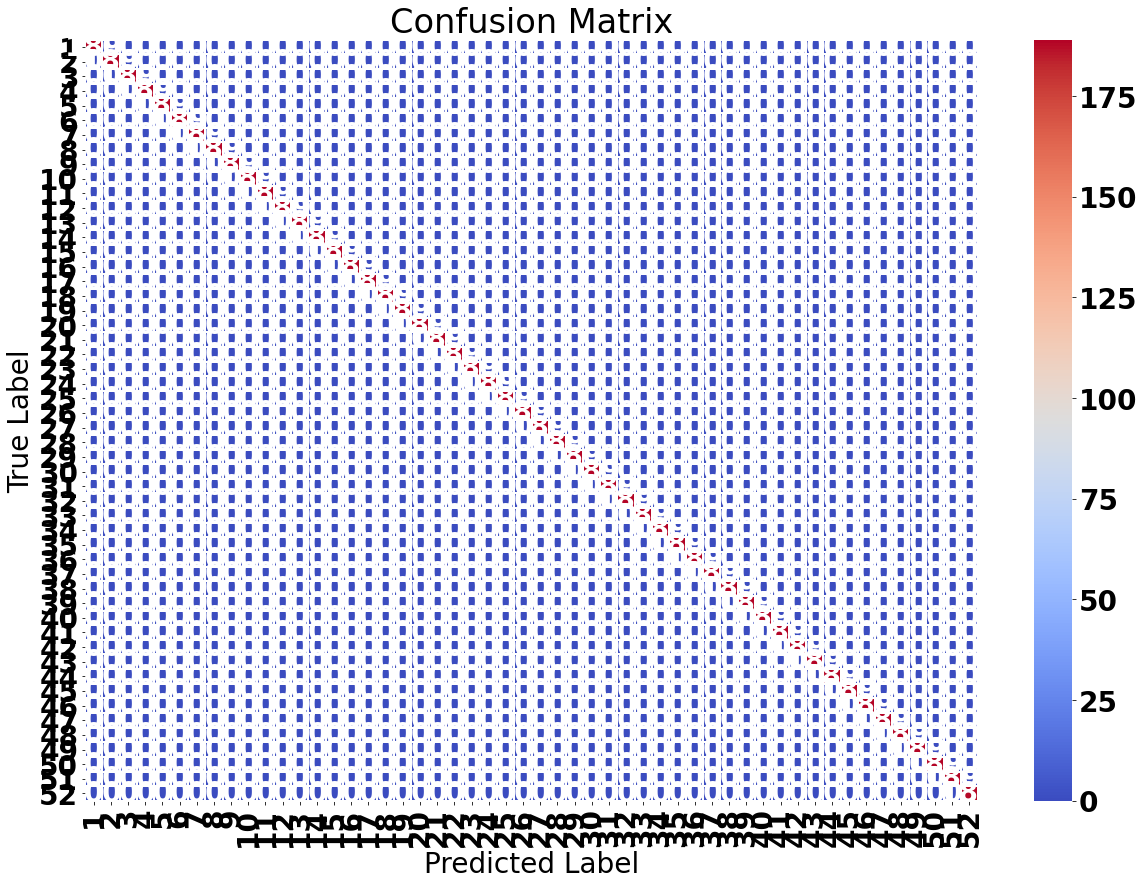

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00       189
           2       1.00      1.00      1.00       189
           3       1.00      1.00      1.00       189
           4       1.00      1.00      1.00       189
           5       1.00      1.00      1.00       189
           6       1.00      1.00      1.00       189
           7       1.00      1.00      1.00       189
           8       1.00      1.00      1.00       189
           9       1.00      1.00      1.00       189
          10       1.00      1.00      1.00       189
          11       1.00      1.00      1.00       189
          12       1.00      1.00      1.00       189
          13       1.00      1.00      1.00       189
          14       1.00      1.00      1.00       189
          15       1.00      1.00      1.00       189
          16       1.00      1.00      1.00       189
          17       1.00    

In [55]:
y_pred_train = model.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#max_y_train = np.argmax(y_train, axis=1)
show_confusion_matrix(y_train, max_y_pred_train)
print(classification_report(y_train, max_y_pred_train))

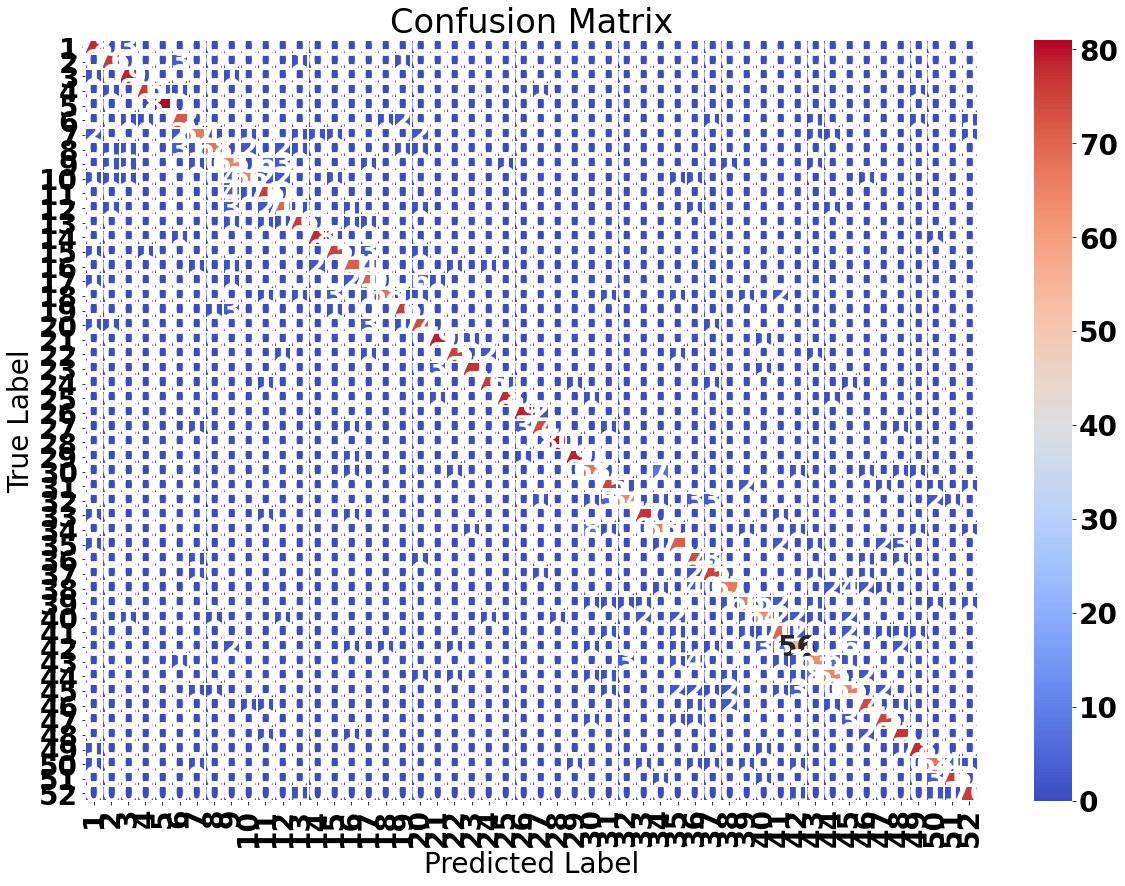

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        81
           1       0.93      0.94      0.93        81
           2       0.91      0.98      0.94        81
           3       0.97      0.94      0.96        81
           4       0.99      1.00      0.99        81
           5       0.87      0.89      0.88        81
           6       0.89      0.83      0.86        81
           7       0.94      0.84      0.89        81
           8       0.76      0.80      0.78        81
           9       0.93      0.81      0.87        81
          10       0.83      0.94      0.88        81
          11       0.88      0.86      0.87        81
          12       0.93      0.94      0.93        81
          13       0.96      0.96      0.96        81
          14       0.91      0.93      0.92        81
          15       0.88      0.88      0.88        81
          16       0.83      0.86      0.85        81
          17       0.97    

In [56]:
y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))